In [13]:
import jax
import jax.numpy as jnp
import optax
from jax import random, grad, value_and_grad
from jax import nn

import numpy as np
import os
import dill

from lib.lib_Adam_FF_cov import (
    Functions,
    AdamTrain
)

from lib.plot_lib import (
    PlotResults
)

PR = PlotResults(Functions)

print(jax.devices())
print(jnp.sin(jnp.pi/2))

%load_ext autoreload
%autoreload 2

[CudaDevice(id=0)]
1.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data_name = 'SNP500'
training_data = np.load(f"training_data/{data_name}.npz")

diff_type = "diagonal"
trajectory_step_size = 1
trajectories = training_data["trajectories"]
D = trajectories.shape[1]

print(trajectories.shape)

(1, 1, 3918)


In [3]:
# ex_name = "ex4-3D_spd"

# # load true functions
# with open(f"true_functions/{ex_name}.pkl", "rb") as f:
#     true_functions = dill.load(f)

# true_drift = true_functions["drift"]
# true_diffusion = true_functions["diffusion"]

# # load data
# data_name = f"{ex_name}_time0.01_SS0.01_ntraj10000"
# training_data = np.load(f"training_data/{data_name}.npz")

# diff_type = str(training_data["diff_type"])
# trajectory_step_size = training_data["step_size"]
# trajectories = training_data["trajectories"]
# D = trajectories.shape[1]

# print(trajectories.shape)

In [4]:
# subsample data
h = 1
sampled_trajectories = trajectories[:, :, ::int(h/trajectory_step_size)]

x_data = sampled_trajectories[:, :, :-1].reshape(-1, D)
y_data = sampled_trajectories[:, :, 1:].reshape(-1, D)

#step_sizes = np.zeros((x_data.shape[0], 1)) + step_size

key = random.PRNGKey(0)

print(x_data.shape)


(3917, 1)


In [10]:
pretrain = True

if pretrain:
    # load pretrained network
    ARFF_data = np.load(f"saved_results/param/{data_name}_ARFF_trig.npz", allow_pickle=True)
    # unwrap the dict, keep complex dtype
    drift_param = {k: jnp.array(v) for k, v in ARFF_data["drift_param"].item().items()}
    diff_param  = {k: jnp.array(v) for k, v in ARFF_data["diff_param"].item().items()}
    
    # # apply cauchy schwarz sqrt approximation
    # diff_param["amp"] = jnp.sqrt(diff_param["amp"].astype(jnp.complex64))
    # diff_param["omega"] = (diff_param["omega"] / 2.0).astype(jnp.complex64)

else:
    # create network
    K = 2**7
    if diff_type == "diagonal":
        a = D
    else:
        a = int(D*(D+1)/2)
    
    
    # --- Define drift NN (f_theta) ---
    def init_drift_params(key):
        k1, k2 = random.split(key)
        return {
            "omega": random.normal(k1, (D, K)) * 0.01,
            "amp": random.normal(k2, (2*K, D)) * 0.01
        }
    
    # --- Define diffusion NN (sigma_theta') that outputs lower-triangular matrix ---
    def init_diffusion_params(key):
        k1, k2 = random.split(key)
        return {
            "omega": random.normal(k1, (D, K)) * 0.01,
            "amp": random.normal(k2, (2*K, a)) * 0.01
        }

    
    # def glorot_uniform(key, shape):
    #     fan_in, fan_out = shape[0], shape[1]
    #     limit = jnp.sqrt(6.0 / (fan_in + fan_out))
    #     return random.uniform(key, shape, minval=-limit, maxval=limit, dtype=jnp.float64)
    
    # def init_drift_params(key):
    #     k1, k2, k3, k4 = random.split(key, 4)
    #     return {
    #         "W1": glorot_uniform(k1, (D, K)),    # input → hidden
    #         "b1": jnp.zeros((K,), dtype=jnp.float64),
    #         "W2": glorot_uniform(k2, (K, D)),    # hidden → output
    #         "b2": jnp.zeros((D,), dtype=jnp.float64),
    #         "amp": jnp.zeros((1, a))
    #     }
    
    # def small_uniform(key, shape):
    #     return random.uniform(key, shape, minval=-1e-2, maxval=1e-2, dtype=jnp.float64)
    
    # def init_diffusion_params(key):
    #     k1, k2, k3, k4 = random.split(key, 4)
    #     return {
    #         "W1": small_uniform(k1, (D, K)),
    #         "b1": small_uniform(k2, (K,)),
    #         "W2": small_uniform(k3, (K, a)),
    #         "b2": small_uniform(k4, (a,)),
    #         "amp": jnp.zeros((1, a))
    #     }


    # --- Initialize ---
    key1, key2, key3 = random.split(key, 3)
    drift_param = init_drift_params(key1)
    diff_param = init_diffusion_params(key2)


In [37]:
print(AdamTrain.nll_loss(drift_param, diff_param, x_data, y_data, h, diff_type))

4.768976359979052


In [38]:
hyperparams = {"epochs": 1000, "learning_rate": 1e-8, "batch_size": None}
Adam_drift_param, Adam_diff_param, times, losses, val_losses = AdamTrain.training_loop(hyperparams, drift_param, diff_param, x_data, y_data, h, diff_type, val_split=0.1)


epoch 999: loss = 4.6164, val_loss = 5.50566


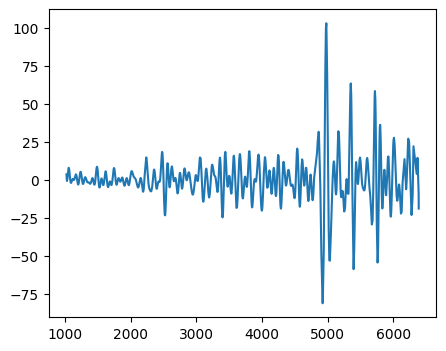

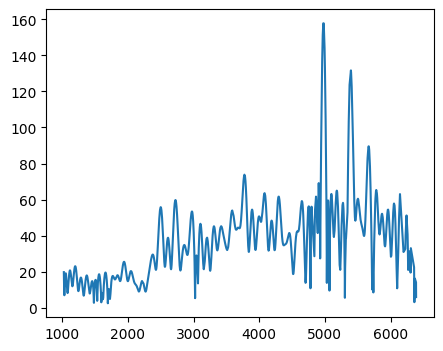

In [39]:
PR.plot_train_v_true(Adam_drift_param, x_data)
PR.plot_train_v_true(Adam_diff_param, x_data, diff_type=diff_type)
#print(losses)

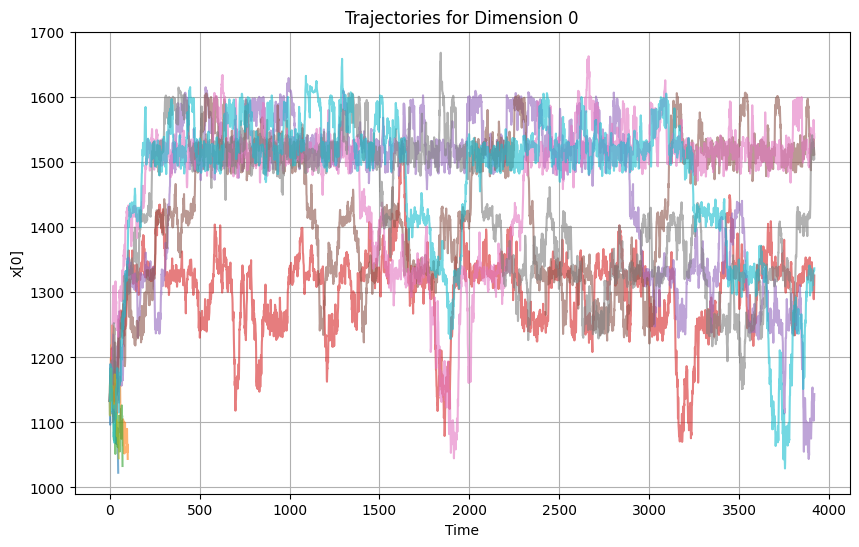

Array([[[1133.        , 1111.33358663, 1096.56589722, ...,
                   nan,           nan,           nan]],

       [[1133.        , 1157.74742812, 1165.09744636, ...,
                   nan,           nan,           nan]],

       [[1133.        , 1144.52077743, 1139.88790223, ...,
                   nan,           nan,           nan]],

       ...,

       [[1133.        , 1154.33268809, 1161.00920428, ...,
         1517.48599255, 1511.83777235, 1505.72287571]],

       [[1133.        , 1110.84748323, 1150.0341836 , ...,
                   nan,           nan,           nan]],

       [[1133.        , 1152.96127805, 1171.54644813, ...,
         1335.73316866, 1333.25580061, 1336.92095324]]], dtype=float64)

In [40]:
x_domain = np.array([[1133, 1133]])
xlim = np.array([[min(x_data), max(x_data)]])

n_trajectories = 10
trajectory_time = 3918
step_size = 1

PR.plot_trajectories(drift_param, diff_param, x_domain, xlim, n_trajectories, trajectory_time, h, diff_type)

In [ ]:
# if pretrain:
#     times += ARFF_data["times"]
np.savez(f"saved_results/shallow_NN_param/{ex_name}_Adam_diff_pretrain_sqrt.npz", drift_param=Adam_drift_param, diff_param=Adam_diff_param, times=times, losses=losses, val_losses=val_losses)
